<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/05_Relation_Extraction/Gold_standard_dataset.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
     alt="Open in Colab">
</a>



# Relation Extraction gold standard dataset

## 1. Introduction

Relation extraction in biomedical applications presents a unique set of challenges compared to traditional NLP tasks, including complex domain-specific language and highly nuanced relationships between entities ([Moscato, V. et al., 2023](https://link.springer.com/article/10.1007/s10462-023-10484-6)). Another important challenge is the lack of large and high-quality annotated training datasets for relation extraction in the biomedical domain. The annotation process is time-consuming and requires extensive domain knowledge, making it expensive to obtain large amounts of annotated data.

We will build a custom gold standard annotated dataset for supervised fine-tuning of an LLM for biomedical relation extraction using openly available software tools developed by researchers at the [MRC Integrative Epidemiology Unit](https://mrcieu.github.io/) (IEU) at the University of Bristol.



## 2. Install/import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import json
import pickle

from time import sleep

## 3. MELODI Presto

[SemMedDB](https://skr3.nlm.nih.gov/SemMedDB/) (The Semantic MEDLINE Database) is a well established database that provides subject-predicate-object triples extracted from all PubMed titles and abstracts by [SemRep](https://lhncbc.nlm.nih.gov/ii/tools/SemRep_SemMedDB_SKR/SemRep.html), a semantic interpreter of biomedical text. Using a subset of this data the MRC IEU created [MELODI Presto](https://melodi-presto.mrcieu.ac.uk/), a method to assign triples to any given biomedical query via a PubMed search and some basic enrichment.

MELODI Presto is a faster and more agile tool than [MELODI](https://pubmed.ncbi.nlm.nih.gov/29342271/) (Mining Enriched Literature Objects to Derive Intermediates) for providing simple methods to explore both enriched triples from single queries, and overlapping triples across two query lists.

The [web application](https://melodi-presto.mrcieu.ac.uk/app/) demonstrates the three functions MELODI Presto provides:

1.   [Enrich](https://melodi-presto.mrcieu.ac.uk/app/enrich) - Return the enriched semantic triples for a list of query terms
2.   [Overlap](https://melodi-presto.mrcieu.ac.uk/app/overlap) - Return the overlapping enriched semantic triples for two lists of queries
3.   [Sentence](https://melodi-presto.mrcieu.ac.uk/app/sentence) - Return the semantic triples for a given PubMed ID



### 3.1 API

Full details can be found at https://melodi-presto.mrcieu.ac.uk/docs/ for the API endpoints for the three functions.

We will refer to the [demo notebook showing API usage](https://github.com/MRCIEU/MELODI-Presto/blob/main/notebooks/api-demo.ipynb) to extract data to build our training dataset.



In [ ]:
# Set the API endpoint URL as a configurable parameter
API_URL = "https://melodi-presto.mrcieu.ac.uk/api/"

# Check connection
requests.get(f"{API_URL}/status").json()

True

### 3.2 Sentence function for PubMed IDs

As demonstrated in the notebook, we will define a function for the sentence endpoint to retrieve the SemMedDB data for a given PubMed ID, including the sentence and  subject-predicate-object triples, and convert the JSON output into a DataFrame.

In [ ]:
# define function for the sentence API endpoint
def sentence(q):
    endpoint = "/sentence/"
    url = f"{API_URL}{endpoint}"
    params = {
        "pmid": pmid,
    }
    response = requests.post(url, data=json.dumps(params))
    res = response.json()
    pub_df = (
        pd.json_normalize(res['data'])
    )
    return pub_df

We will call the function for a sample PubMed ID.

In [ ]:
# Retrieve the SemMedDB data for a given PubMed ID

pmid = '33074111'
pub_df = sentence(pmid)
pub_df

,PREDICATION_ID,SENTENCE_ID,PMID,PREDICATE,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,SUB_PRED_OBJ,TYPE,NUMBER,SENT_START_INDEX,SENTENCE,SENT_END_INDEX,ISSN,DP,EDAT,PYEAR
0,189905860,358489581,33074111,INTERACTS_WITH,C0292818,ritonavir,orch,C0020336,hydroxychloroquine,orch,ritonavir:INTERACTS_WITH:hydroxychloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
1,189905862,358489581,33074111,INTERACTS_WITH,C0292818,ritonavir,orch,C0008269,chloroquine,orch,ritonavir:INTERACTS_WITH:chloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
2,189905863,358489581,33074111,INTERACTS_WITH,C0674432,lopinavir,orch,C0008269,chloroquine,orch,lopinavir:INTERACTS_WITH:chloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
3,189905864,358489581,33074111,INTERACTS_WITH,C0674432,lopinavir,orch,C0020336,hydroxychloroquine,orch,lopinavir:INTERACTS_WITH:hydroxychloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
4,189905861,358489581,33074111,INTERACTS_WITH,C0292818,ritonavir,orch,C1138226,favipiravir,orch,ritonavir:INTERACTS_WITH:favipiravir,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
5,189905865,358489581,33074111,INTERACTS_WITH,C0674432,lopinavir,orch,C1138226,favipiravir,orch,lopinavir:INTERACTS_WITH:favipiravir,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020


We will define a function to retrieve data for a list of PubMed IDs, and concatenate and reindex DataFrames.

In [ ]:
def get_semmeddb_data(pmids):
    """
    Retrieve SemMedDB data for a list of PubMed IDs, concatenate them into a single DataFrame, and reindex the DataFrame.

    Args:
    pmids (list): List of PubMed IDs.

    Returns:
    DataFrame: A DataFrame containing the concatenated SemMedDB data for all provided PubMed IDs, reindexed.
    """
    # Initialise an empty list to store DataFrames
    data_frames = []

    # Iterate over the list of PMIDs
    for pmid in pmids:
        try:
            # Retrieve the SemMedDB data for the given PMID
            pub_df = sentence(pmid)

            # Append the retrieved data to the list of DataFrames
            data_frames.append(pub_df)
        except Exception as e:
            # Print an error message if data retrieval fails for a PMID
            print(f"Error retrieving data for PMID {pmid}: {e}")

    # Concatenate all DataFrames in the list into a single DataFrame and reset the index
    if data_frames:
        appended_df = pd.concat(data_frames, ignore_index=True)
    else:
        # If no data was retrieved, create an empty DataFrame
        appended_df = pd.DataFrame()

    return appended_df

We will call the function for a list of PubMed IDs.

In [ ]:
pmids = ['33074111', '33246398']

pmid_df = get_semmeddb_data(pmids)
pmid_df


,PREDICATION_ID,SENTENCE_ID,PMID,PREDICATE,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,SUB_PRED_OBJ,TYPE,NUMBER,SENT_START_INDEX,SENTENCE,SENT_END_INDEX,ISSN,DP,EDAT,PYEAR
0,189905860,358489581,33074111,INTERACTS_WITH,C0292818,ritonavir,orch,C0020336,hydroxychloroquine,orch,ritonavir:INTERACTS_WITH:hydroxychloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
1,189905862,358489581,33074111,INTERACTS_WITH,C0292818,ritonavir,orch,C0008269,chloroquine,orch,ritonavir:INTERACTS_WITH:chloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
2,189905863,358489581,33074111,INTERACTS_WITH,C0674432,lopinavir,orch,C0008269,chloroquine,orch,lopinavir:INTERACTS_WITH:chloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
3,189905864,358489581,33074111,INTERACTS_WITH,C0674432,lopinavir,orch,C0020336,hydroxychloroquine,orch,lopinavir:INTERACTS_WITH:hydroxychloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
4,189905861,358489581,33074111,INTERACTS_WITH,C0292818,ritonavir,orch,C1138226,favipiravir,orch,ritonavir:INTERACTS_WITH:favipiravir,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
5,189905865,358489581,33074111,INTERACTS_WITH,C0674432,lopinavir,orch,C1138226,favipiravir,orch,lopinavir:INTERACTS_WITH:favipiravir,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
6,189905860,358489581,33074111,INTERACTS_WITH,C0292818,ritonavir,orch,C0020336,hydroxychloroquine,orch,ritonavir:INTERACTS_WITH:hydroxychloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
7,189905862,358489581,33074111,INTERACTS_WITH,C0292818,ritonavir,orch,C0008269,chloroquine,orch,ritonavir:INTERACTS_WITH:chloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
8,189905863,358489581,33074111,INTERACTS_WITH,C0674432,lopinavir,orch,C0008269,chloroquine,orch,lopinavir:INTERACTS_WITH:chloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020
9,189905864,358489581,33074111,INTERACTS_WITH,C0674432,lopinavir,orch,C0020336,hydroxychloroquine,orch,lopinavir:INTERACTS_WITH:hydroxychloroquine,ab,8,1929,Remdesvir showed better binding to the priorit...,2202,1879-0534,2020 Oct 14,2020-10-19,2020


### 3.3 Enrich function for PubMed search

As demonstrated in the notebook, we will define a function for the enrich endpoint to return all SemMedDB subject-predicate-object triples, their enrichment metrics, and publication information for a PubMed search.

In [ ]:
def enrich(q):
    endpoint = "/enrich/"
    url = f"{API_URL}{endpoint}"
    params = {
        "query": q,
    }
    response = requests.post(url, data=json.dumps(params))
    try:
        res = response.json()
        enrich_df = (
                pd.json_normalize(res)
        )
        return enrich_df
    except:
        print('No data')
        return []

We will call the function for the query 'COVID-19 drug repurposing' and analyse frequency of predicates, subject and object entities.


In [ ]:
query_term='COVID-19 drug repurposing'

enrich_df = enrich(query_term)
enrich_df

,query,triple,subject_name,subject_type,subject_id,predicate,object_name,object_type,object_id,localCount,localTotal,globalCount,globalTotal,odds,pval,pmids
0,covid-19_drug_repurposing,hydroxychloroquine:TREATS:COVID-19,hydroxychloroquine,orch,C0020336,TREATS,COVID-19,dsyn,C5203670,45,1142,580,8040465,568.627330,2.960991e-105,33742617 33617702 33480414 33408029 33408025 3...
1,covid-19_drug_repurposing,Vaccines:TREATS:COVID-19,Vaccines,phsu,C0042210,TREATS,COVID-19,dsyn,C5203670,35,1142,345,8040465,736.824162,4.563689e-86,33896155 33811458 33743371 33686365 33605735 3...
2,covid-19_drug_repurposing,chloroquine:TREATS:COVID-19,chloroquine,orch,C0008269,TREATS,COVID-19,dsyn,C5203670,25,1142,222,8040465,810.593348,5.770882e-63,33907517 33906514 33617702 33188451 33152192 3...
3,covid-19_drug_repurposing,Antiviral Agents:TREATS:COVID-19,Antiviral Agents,phsu,C0003451,TREATS,COVID-19,dsyn,C5203670,18,1142,164,8040465,785.117492,1.484098e-45,33907209 33724123 33676899 33645457 33355053 3...
4,covid-19_drug_repurposing,remdesivir:TREATS:COVID-19,remdesivir,phsu,C4726677,TREATS,COVID-19,dsyn,C5203670,11,1142,313,8040465,249.833114,3.778864e-23,33585508 33453396 33345645 33239864 32972027 3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,covid-19_drug_repurposing,ambroxol:INHIBITS:SPHINGOMYELINASE,ambroxol,orch,C0002421,INHIBITS,SPHINGOMYELINASE,gngm,C0037903,2,1142,2,8040465,7053.037719,1.208747e-07,33895135
98,covid-19_drug_repurposing,Antibodies:TREATS:COVID-19,Antibodies,phsu,C0003241,TREATS,COVID-19,dsyn,C5203670,2,1142,60,8040465,235.099561,3.788748e-05,33896155 33300456
99,covid-19_drug_repurposing,hydroxychloroquine:COEXISTS_WITH:estrogen rece...,hydroxychloroquine,orch,C0020336,COEXISTS_WITH,"estrogen receptor alpha, human",aapp,C1521863,2,1142,5,8040465,2821.214035,4.229414e-07,33620659 32693652
100,covid-19_drug_repurposing,metformin:INTERACTS_WITH:Blood Glucose,metformin,orch,C0025598,INTERACTS_WITH,Blood Glucose,orch,C0005802,2,1142,34,8040465,414.882921,1.265352e-05,33609563


The most frequently occurring triple for this query is `hydroxychloroquine:TREATS:COVID-19` which occurs 45 times out of a total of 1142 triples.

In [ ]:
with open('2024-06-06_semmeddb_triples_df.pickle', "wb") as f:
    pickle.dump(enrich_df, f)

In [ ]:
enrich_df.to_csv('2024-06-07_semmeddb_triples.csv', index=False)

## 4. Plot frequency of relations

In [ ]:
def plot_frequency(df, column_name, x_label, y_label, title):
    """
    Plot the frequency of values in the specified column of the given DataFrame.

    Args:
    df (DataFrame): DataFrame containing the entities.
    column_name (str): Name of the column to plot the frequency of values from.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    title (str): Title of the plot.

    Returns:
    None (displays the plot)
    """
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")

    # Count the frequency of each entity or relation in the specified column
    val_counts = df[column_name].value_counts()

    # Plotting
    plt.figure(figsize=(10, 6))
    val_counts.plot(kind='bar')

    # Adding labels and title
    plt.xticks(rotation=70)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()

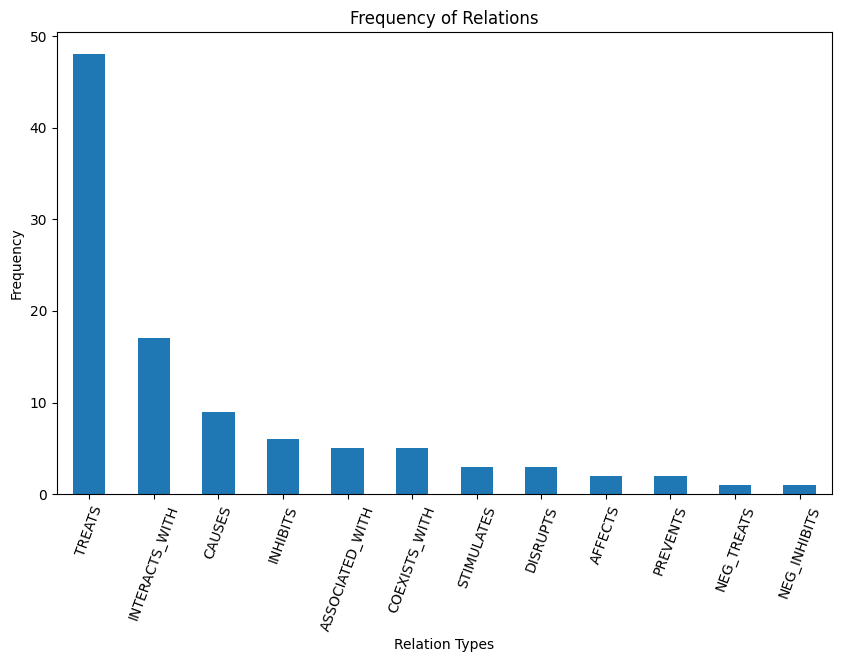

In [ ]:
plot_frequency(enrich_df, 'predicate', 'Relation Types', 'Frequency', 'Frequency of Relations')

'TREATS' is by far the most common of the 12 predicates.

## 5. Entity counts

### 5.1 Subject entities and counts

In [ ]:
# Display the counts without truncation
pd.set_option('display.max_rows', None)

In [ ]:
enrich_df.subject_name.value_counts()

,count
subject_name,
hydroxychloroquine,8
Antiviral Agents,6
chloroquine,5
sphingosine 1-phosphate,3
angiotensin converting enzyme 2,3
Vaccines,3
famotidine,3
metformin,2
COVID-19,2


Hydroxychloroquine is the most frequently occurring subject entity.

In [ ]:
enrich_df.subject_name.unique()

array(['hydroxychloroquine', 'Vaccines', 'chloroquine',
       'Antiviral Agents', 'remdesivir', 'dexamethasone', 'ivermectin',
       'Coronavirus Infections', 'Anti-Inflammatory Agents',
       'nitazoxanide', 'Vitronectin, human',
       'Hydroxymethylglutaryl-CoA Reductase Inhibitors', 'baricitinib',
       'Drug Combinations', 'Immunologic Adjuvants', 'tocilizumab',
       'Interferons', 'Protease Inhibitors',
       'Severe Acute Respiratory Syndrome', 'famotidine', 'Antimalarials',
       'darunavir', 'diethylcarbamazine', 'saquinavir', 'metformin',
       'Peptide Hydrolases', 'COVID-19', 'pentoxifylline',
       'RNA Recognition Motif', 'RRx-001', 'Viral Proteins', 'raloxifene',
       'Investigational New Drugs', 'Small Molecule', 'toremifene',
       'acetylcysteine', 'Antioxidants', 'Monoclonal Antibodies',
       'ascorbic acid', 'fostamatinib', 'boceprevir',
       'angiotensin converting enzyme 2', 'thalidomide', 'itraconazole',
       'colchicine', 'pyronaridine', 'ralt

In [ ]:
enrich_df.subject_name.nunique()

72

### 5.2 Object entities and counts

In [ ]:
enrich_df.object_name.value_counts()

object_name
COVID-19                                       54
Peptide Hydrolases                              7
angiotensin converting enzyme 2                 3
Severe Acute Respiratory Syndrome               3
Virus Diseases                                  3
M Protein, multiple myeloma                     2
Malaria                                         2
Collagen Diseases                               2
TMPRSS2 gene|TMPRSS2                            2
Chagas Disease                                  1
ketotifen                                       1
Viral Proteins                                  1
8-chloro-cyclic adenosine monophosphate         1
African Trypanosomiasis                         1
ACE2 gene|ACE2                                  1
Leishmaniasis                                   1
spike protein, SARS-CoV-2                       1
SPHINGOMYELINASE                                1
estrogen receptor alpha, human                  1
cytokine                              

'COVID-19' appears 54 times as an object entity but only twice as a subject entity.

In [ ]:
enrich_df.object_name.unique()

array(['COVID-19', 'Malaria', 'angiotensin converting enzyme 2',
       'Peptide Hydrolases', 'Severe Acute Respiratory Syndrome',
       'Cytokine Storm', 'Autoimmune thrombocytopenia',
       'M Protein, multiple myeloma', 'Coronavirus Infections',
       'Collagen Diseases', 'Interferons', 'Complement C5a',
       'TMPRSS2 gene|TMPRSS2', 'Bradykinin Receptor',
       'Vitronectin, human', 'glycyrrhizic acid',
       'Chronic idiopathic thrombocytopenic purpura',
       'Anti-Inflammatory Agents', 'Virus Diseases', 'proline',
       'Serine Endopeptidases', 'Leishmaniasis', 'cytokine', 'ketotifen',
       'Viral Proteins', '8-chloro-cyclic adenosine monophosphate',
       'Chagas Disease', 'ACE2 gene|ACE2', 'African Trypanosomiasis',
       'spike protein, SARS-CoV-2', 'SPHINGOMYELINASE',
       'estrogen receptor alpha, human', 'Blood Glucose'], dtype=object)

In [ ]:
enrich_df.object_name.nunique()

33

There are fewer unique object entities than unique subject entities.

The most frequently occurring predicate (TREATS), subject (hydroxychloroquine) and object entity (COVID-19) confirms the occurrence of `hydroxychloroquine:TREATS:COVID-19` as the most frequent triple. This is logical given that the search query was 'COVID-19 drug repurposing'.

## 6. Get sentences for triples

We will use the output for the PubMed search for 'COVID-19 drug repurposing' to create the annotated training dataset.

In [ ]:
# list of PubMed IDS containing most frequently occurring triple
enrich_df.pmids[0]

'33742617 33617702 33480414 33408029 33408025 33408024 33408022 33408021 33408017 33408016 33408014 33364965 33204210 33115586 33100674 33044019 32981089 32972027 32864299 32860962 32853673 32848158 32828135 32827400 32823144 32693652 32639233 32552642 32542964 32528194 32522067 32415419 32304640 32285930'

In [ ]:
type(enrich_df.pmids[0])

str

We will define a function to return a list of unique sentences for a given PubMed ID.

In [ ]:
def get_sentence_data(pmid):
    url = "https://melodi-presto.mrcieu.ac.uk/api/sentence/"
    params = {"pmid": pmid}
    response = requests.post(url, data=json.dumps(params))
    response.raise_for_status()
    res = response.json()
    if "data" in res:
        df = pd.json_normalize(res["data"])
        if len(df) > 0:
            return df["SENTENCE"].drop_duplicates().tolist()
    return []

We will also define a helper function to iterate through the rows in the enrich DataFrame and, for each PubMed ID for a given triple, print the triple followed by all the unique sentences containing that triple.

In [ ]:
def process_pmids(enrich_df):
    for idx, data in enrich_df.iterrows():
        pmids = data["pmids"].split()  # Convert the string of PMIDs into a list
        triple = data["triple"]
        print(f"\n### {triple} ###\n")

        sentence_results = []
        for pmid in pmids:
            try:
                sentences = get_sentence_data(pmid)
                sentence_results.extend(sentences)
            except Exception as e:
                print(f"Error retrieving data for PMID {pmid}: {e}")

        # Print sentences for each PMID
        for sentence in sentence_results:
            print(sentence, "\n")

We will test the above function for two rows in the enrich DataFrame.

In [ ]:
process_pmids(enrich_df[100:102])


### metformin:INTERACTS_WITH:Blood Glucose ###

Direct/indirect activation of Adenosine Monophosphate-activated protein kinase (AMPK) and non-AMPK pathways, amongst others, are deemed to explain the molecular mechanisms of action of metformin. 

Non-glycemic effects of metformin favorable to its repurposing in therapeutic use are hereby discussed. 

Metformin turns 62 in Pharmacotherapy: emergence of non-glycaemic effects and potential novel Therapeutic applications. 

Emerging experimental and clinical evidence suggests that metformin has pleiotropic non-glycemic effects. 

Metformin appears to have weight stabilizing, renoprotective, neuroprotective, cardio-vascular protective, and antineoplastic effects and mitigates polycystic ovarian syndrome. 


### Cytokine Storm:COEXISTS_WITH:COVID-19 ###

In this Perspective article we discuss the evidence for synergistic anti-inflammatory and immunomodulatory properties exerted by vitamin D and dipeptidyl peptidase-4 (DPP-4) inhibitors, the 

### 6.1 Select sentences by predicate

We will refer to the enrich data saved as a csv and select two rows for each unique predicate type. We did not select the two inverse relations `NEG_TREATS` and `NEG_INHIBITS` as we did not explicitly include these in the predefined list of SemRep predicates previously given as context in the system message to the Llama3-70b base model. This is likely to affect our supervised fine-tuned model's ability to identify inverse relations and would be a future improvement.



#### TREATS

In [ ]:
indices_to_process = [0, 14]
treats = process_pmids(enrich_df.iloc[indices_to_process])


### hydroxychloroquine:TREATS:COVID-19 ###

CONCLUSIONS: QTc monitoring using smartphone electrocardiogram was feasible in COVID-19 patients treated with hydroxychloroquine with or without lopinavir-ritonavir. 

Smartphone electrocardiogram for QT interval monitoring in Coronavirus Disease 2019 (COVID-19) patients treated with Hydroxychloroquine. 

Chloroquine and Hydroxychloroquine for the Treatment of COVID-19: Review and Appraisal of Current Evidence. 

Cohort studies that assessed the use of HCQ for COVID-19 reported conflicting results, but randomized controlled trials (RCTs) demonstrated no effect on mortality rates and no substantial clinical benefits of HCQ used either for prevention or treatment of COVID-19. 

Effect of hydroxychloroquine and azithromycin as a treatment of COVID-19: results of an open-label non-randomized clinical trial, an update with an intention-to-treat analysis and clinical outcomes. 

Safety profile of hydroxychloroquine and azithromycin combined treatm

#### CAUSES

In [ ]:
indices_to_process = [7, 31]
causes = process_pmids(enrich_df.iloc[indices_to_process])


### Coronavirus Infections:CAUSES:COVID-19 ###

The ongoing COVID-19 pandemic caused by the coronavirus, SARS-CoV-2, has already caused in excess of 1.25 million deaths worldwide, and the number is increasing. 

COVID-19, caused by a novel coronavirus, SARS-CoV-2, has spread globally and caused serious social and economic problems. 

COVID-19, caused by novel coronavirus or SARS-CoV-2, is a viral disease which has infected millions worldwide. 

COVID-19: Antiviral Agents, Antibody Development and Traditional Chinese Medicine.The World Health Organization (WHO) has declared coronavirus disease 2019 (COVID-19) is the first pandemic caused by coronavirus named severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). 

Repurposing simeprevir, calpain inhibitor IV and a cathepsin F inhibitor against SARS-CoV-2 and insights into their interactions with M     pro      .The world has come to a sudden halt due to the incessant spread of a viral pneumonia dubbed COVID-19 caused by the beta

#### INTERACTS_WITH

In [ ]:
indices_to_process = [11, 39]
interacts_with = process_pmids(enrich_df.iloc[indices_to_process])


### Vitronectin, human:INTERACTS_WITH:angiotensin converting enzyme 2 ###

S-protein interacts with human angiotensin-converting-enzyme-2 (ACE2) for entering the cell. 

S-protein is a large protein and a portion of it designated as a receptor-binding domain (RBD) is the key region that interacts with ACE2, following to which the viral membrane fuses with the alveolar membrane to enter the human cell. 

In Silico     Structure-Based Repositioning of Approved Drugs for Spike Glycoprotein S2 Domain Fusion Peptide of SARS-CoV-2: Rationale from Molecular Dynamics and Binding Free Energy Calculations.The membrane-anchored spike (S) protein of severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) has a pivotal role in directing the fusion of the virus particle mediated by the host cell receptor angiotensin-converting enzyme 2 (ACE-2). 

In general, all CoVs including SARSCoV-2 are spherical positive single-stranded RNA viruses containing spike (S) protein, envelope (E) protein, nucle

#### STIMULATES

In [ ]:
indices_to_process = [18, 40]
stimulates = process_pmids(enrich_df.iloc[indices_to_process])


### Interferons:STIMULATES:angiotensin converting enzyme 2 ###

Few COVID-19 therapeutics are available, and the basis for severe infections is poorly understood. 

However, recent studies highlight the potential for IFNs to enhance expression of host angiotensin-converting enzyme 2 (ACE2), suggesting that IFN therapy or natural coinfections could exacerbate COVID-19 by upregulating this critical virus entry receptor. 

We observed differences between IFNs with respect to their induction of antiviral genes and abilities to enhance the cell surface expression of ACE2. 

Nevertheless, IFNs can have undesirable side effects, and recent reports indicate that IFNs upregulate the expression of host ACE2 (a critical entry receptor for SARS-CoV-2), raising the possibility that IFN treatments could exacerbate COVID-19. 

Our data imply that type-specific mechanisms or kinetics shape IFN-enhanced ACE2 transcript and cell surface levels but that the antiviral action of IFNs against SARS-CoV-2 co

#### AFFECTS

In [ ]:
indices_to_process = [22, 80]
affects = process_pmids(enrich_df.iloc[indices_to_process])


### hydroxychloroquine:AFFECTS:COVID-19 ###

Does hydroxychloroquine still have any role in the COVID-19 pandemic? 

No antiviral drugs have proven life-saving in late-stage COVID-19. 

Therapeutic status of hydroxychloroquine in COVID-19: A review. 

Hydroxychloroquine (HCQ), a 4-aminoquinoline, is used worldwide mainly for its role in management of malaria and rheumatoid arthritis. 

There has been a lot of information, for and against the drug, and this review is an effort to bring forth the evidence and current understanding regarding role of HCQ in COVID-19. 

Hydroxychloroquine in COVID-19: Potential Mechanism of Action Against SARS-CoV-2. 

The existing literature hints that till date, the role of CQ/HCQ in COVID-19 may be sceptical, and further studies are warranted for obtaining a therapeutic option that could be effectively used across the world to rise out from this pandemic. 

On the other hand, this review also makes an honest attempt to delineate mechanisms (increase in 

#### ASSOCIATED_WITH

In [ ]:
indices_to_process = [29, 92]
associated_with = process_pmids(enrich_df.iloc[indices_to_process])


### Peptide Hydrolases:ASSOCIATED_WITH:COVID-19 ###

The major protease (M      pro      ), and RNA-dependent RNA polymerase (RdRp) are two target proteins in SARS-CoV-2 that have been validated and extensively studied for drug development in COVID-19. 

In this study, we extend previous research by performing docking and MD simulation studies coupled with an MM/GBSA approach to assess binding of dimeric SARS-CoV2 M     pro       to 12 FDA-approved drugs (darunavir, indinavir, saquinavir, tipranavir, diosmin, hesperidin, rutin, raltegravir, velpatasvir, ledipasvir, rosuvastatin, and bortezomib), which were identified as the best candidates for the treatment of COVID-19 in some previous dockings studies involving monomeric SARS-CoV2 M     pro      . 

Study of embelin and two therapeutic compounds of interest, methyl prednisolone and dexamethasone.BACKGROUND: Quinones are reactive to proteins containing cysteine residues and the main protease in Covid-19 contains an active site that in

#### CO-EXISTS_WITH

In [ ]:
indices_to_process = [34, 101]
coexists_with = process_pmids(enrich_df.iloc[indices_to_process])


### RNA Recognition Motif:COEXISTS_WITH:M Protein, multiple myeloma ###

For this purpose, five proteins of COVID-19 (3-chymotrypsin-like protease (3CLpro), Papain-Like protease (PLpro), cleavage site, HR1 and RBD in Spike protein) were selected as target proteins for drug repositioning. 

Then FDA-approved drugs (2471 drugs) were screened against cleavage site and RBD in Spike protein via virtual screening. 

One hundred and twenty-eight FDA-approved drugs with the most favorable free-binding energy were attached to the cleavage site and RBD in Spike protein. 


### Cytokine Storm:COEXISTS_WITH:COVID-19 ###

In this Perspective article we discuss the evidence for synergistic anti-inflammatory and immunomodulatory properties exerted by vitamin D and dipeptidyl peptidase-4 (DPP-4) inhibitors, the latter being a class of antihyperglycemic agents used for the treatment of Type 2 diabetes, which have also been reported as immunomodulators. 

Cytokine storm modulation in COVID-19: a propos

#### INHIBITS

In [ ]:
indices_to_process = [44, 72]
inhibits = process_pmids(enrich_df.iloc[indices_to_process])


### Small Molecule:INHIBITS:Bradykinin Receptor ###

Molecular Features of Non-Selective Small Molecule Antagonists of the Bradykinin Receptors. 


### etoricoxib:INHIBITS:cytokine ###

The emergence of COVID-19-mediated cytokine storm is one of the most important contributors to the development of acute and severe illness in patients. 

This article introduces a potential repositioning of the existing drug etoricoxib, which may inhibit cytokine storm to treat COVID-19 through reducing the activity of Cyclooxygenase-2 in the conversion of arachidonic acid to prostaglandin. 

Etoricoxib may inhibit cytokine storm to treat COVID-19. 



#### DISRUPTS

In [ ]:
indices_to_process = [52, 75]
disrupts = process_pmids(enrich_df.iloc[indices_to_process])


### chloroquine:DISRUPTS:Virus Diseases ###

Preliminary studies on the quinoline medications, Chloroquine and Hydroxy chloroquine, against SARS-CoV2, have shown to be a potential area of interest for drug development, due to their ability to prevent viral entry, act as anti-inflammatory modulators, and inhibit key enzymes allowing reduced viral infectivity. 


### hydroxychloroquine:DISRUPTS:COVID-19 ###

Exploring the room for repurposed hydroxychloroquine to impede COVID-19: toxicities and multipronged combination approaches with pharmaceutical insights. 

The well reported and clinically used anti-malarial aminoquinoline drugs (chloroquine and hydroxychloroquine) have shown potential to be repurposed to control the present pandemic by inhibition of COVID-19. 



#### PREVENTS

In [ ]:
indices_to_process = [69, 78]
prevents = process_pmids(enrich_df.iloc[indices_to_process])


### hydroxychloroquine:PREVENTS:COVID-19 ###

Since chloroquine (CQ) and hydroxychloroquine (HCQ) can inhibit the invasion and proliferation of SARS-CoV-2 in cultured cells, the repurposing of these antimalarial drugs was considered a promising strategy for treatment and prevention of COVID-19. 

Here, we aim to answer the question of why these drugs are not effective against the disease by examining the cellular working mechanisms of CQ and HCQ in prevention of SARS-CoV-2 infections. 

Awaiting further developments that can only derive from the results of these prospective randomized CTs, the take-home message of our review is that a correct methodological approach is the key to understanding whether prophylactic HCQ can really represent an effective strategy in preventing COVID-19. 


### melatonin:PREVENTS:Virus Diseases ###

The drug combination of pirfenidone and melatonin has been identified as a candidate treatment that may contribute to reduce the virus infection. 

We also de

We will manually create a csv comprising two sentences for each of the 10 predicate types and the associated PubMed IDs and read it in as a DataFrame.

In [ ]:
semmeddb_train_data_df = pd.read_csv('2024-06-08_semmeddb_train_data.csv', encoding="utf-8")

In [ ]:
semmeddb_train_data_df

,text,article_id
0,Hydroxychloroquine (HCQ) is a promising candid...,PMC7262072
1,Chloroquine (CQ) and Hydroxychloroquine (HCQ) ...,PMC7476892
2,"COVID-19 is caused by a novel corona virus, re...",PMID:32873185
3,The host immune response to COVID-19 can lead ...,PMC7787505
4,The membrane-anchored spike (S) protein of sev...,PMC7511214
5,"Famotidine, a class A G protein-coupled recept...",PMC7355875
6,"However, recent studies highlight the potentia...",PMC7484541
7,"Apart from antivirals, immunotherapeutic strat...",PMC7441891
8,"Hydroxychloroquine (HCQ), a 4-aminoquinoline, ...",PMC7573985
9,"On the other hand, this review also makes an h...",PMC7225253


## 7. KAZU NER and linking

We will perform NER and Linking on the 20 sentences using the KAZU API.

Note that the endpoint in version 2.0 is http://kazu.korea.ac.kr/api/kazu/ner_and_linking , whereas version 1.0 was used here.

In [ ]:
def query_kazu(text: str):
    """Biomedical entity linking API"""

    # KAZU API for cloud service

    url="http://kazu.korea.ac.kr/kazu/ner_and_linking"

    if isinstance(text, str):
        response = requests.post(url, json={'text': text}).json()
        sleep(1)
    else:
      raise TypeError("Need to supply text")

    return response

In [ ]:
def get_entities(text: str):

    entity_list = []

    entity_list.append(query_kazu(text))

    return entity_list

In [ ]:
%%time

parsed_entities = list(map(get_entities, semmeddb_train_data_df.text))
with open('2024-06-08_semmeddb_train_data_labelled.pickle', 'wb') as f:
  pickle.dump(parsed_entities, f)

CPU times: user 270 ms, sys: 40.9 ms, total: 311 ms
Wall time: 35.1 s


In [ ]:
len(parsed_entities)

20

In [ ]:
parsed_entities

[[[{'idx': '5921884adf294748a1964bdf9a67c2b1',
    'sections': [{'text': 'Hydroxychloroquine (HCQ) is a promising candidate for Coronavirus disease of 2019 (COVID-19) treatment.',
      'name': 'na',
      'entities': [{'match': 'Hydroxychloroquine',
        'entity_class': 'drug',
        'spans': [{'start': 0, 'end': 18}],
        'namespace': 'TransformersModelForTokenClassificationNerStep',
        'mention_confidence': 'HIGHLY_LIKELY',
        'mappings': [{'default_label': 'HYDROXYCHLOROQUINE',
          'source': 'CHEMBL',
          'parser_name': 'CHEMBL',
          'idx': 'CHEMBL1535',
          'string_match_strategy': 'ExactMatchMappingStrategy',
          'string_match_confidence': 'HIGHLY_LIKELY',
          'disambiguation_strategy': 'disambiguation_not_required',
          'metadata': {'syn': 'Hydroxychloroquine',
           'mapping_type': 'FDA',
           'data_origin': 'chembl_32_sqlite'}},
         {'default_label': 'HYDROXYCHLOROQUINE',
          'source': 'CHEMBL',

## 8. Postprocessing




### 8.1 Add article ID

We will add `article_id` to all parsed sentences.

In [ ]:
def add_article_id_all(parsed_sents_list, df):
    modified_sents_list = []
    for i, article_data in enumerate(parsed_sents_list):
        article_id = df.iloc[i]['article_id']
        modified_article_data = []  # Initialise modified data for the current article
        for sentence in article_data:
            sentence[0]['article_id'] = article_id
            modified_article_data.append(sentence[0])
        modified_sents_list.append(modified_article_data)
    return modified_sents_list

In [ ]:
all_sents_article_id = add_article_id_all(parsed_entities, semmeddb_train_data_df)

In [ ]:
len(all_sents_article_id)

20

In [ ]:
all_sents_article_id

[[{'idx': '5921884adf294748a1964bdf9a67c2b1',
   'sections': [{'text': 'Hydroxychloroquine (HCQ) is a promising candidate for Coronavirus disease of 2019 (COVID-19) treatment.',
     'name': 'na',
     'entities': [{'match': 'Hydroxychloroquine',
       'entity_class': 'drug',
       'spans': [{'start': 0, 'end': 18}],
       'namespace': 'TransformersModelForTokenClassificationNerStep',
       'mention_confidence': 'HIGHLY_LIKELY',
       'mappings': [{'default_label': 'HYDROXYCHLOROQUINE',
         'source': 'CHEMBL',
         'parser_name': 'CHEMBL',
         'idx': 'CHEMBL1535',
         'string_match_strategy': 'ExactMatchMappingStrategy',
         'string_match_confidence': 'HIGHLY_LIKELY',
         'disambiguation_strategy': 'disambiguation_not_required',
         'metadata': {'syn': 'Hydroxychloroquine',
          'mapping_type': 'FDA',
          'data_origin': 'chembl_32_sqlite'}},
        {'default_label': 'HYDROXYCHLOROQUINE',
         'source': 'CHEMBL',
         'parser_na

In [ ]:
with open('2024-06-08_semmeddb_train_data_labelled_article_id.pickle', 'wb') as f:
   pickle.dump(all_sents_article_id, f)

### 8.2 Update parsed sentences

We will define a function to return a list of dictionaries for all sentences with the following information : `entity_id`,  `entity_type`, `entity`,                     `span_start`, `span_end`,                      `text`, `idx`, and                       `article_id`.

In [ ]:
def get_parsed_sents_kazu(entity_list):
    parsed_sents_nested = []  # Initialise an empty list to store nested lists of sentences for each article
    for article in entity_list:
        article_id = article[0].get('article_id')  # Get the article_id for the entire article
        parsed_sents = []  # Initialise an empty list to store sentences for the current article
        for item in article:
            section = item.get('sections', [{}])[0]  # Accessing the first section, or an empty dictionary if no sections exist
            entities = section.get('entities', [])  # Accessing the 'entities' list inside 'sections'
            if not entities:  # If no entities found in the section, append the sentence without entity details
                parsed_sents.append({
                    'entity_id': None,
                    'entity_type': None,
                    'entity': None,
                    'span_start': None,
                    'span_end': None,
                    'text': section.get('text'),
                    'idx': item.get('idx'),
                    'article_id': article_id
                })
            else:
                for entity in entities:
                    if 'mappings' in entity:  # Checking if 'mappings' key exists
                        entity_id = entity['mappings'][0]['idx']  # Accessing the 'idx' value from the first element of 'mappings' list
                    else:
                        entity_id = entity.get('match')
                    spans_list = entity.get('spans', [])  # Accessing the 'spans' list from the entity dictionary
                    span_start = spans_list[0].get('start') if spans_list else None
                    span_end = spans_list[0].get('end') if spans_list else None
                    parsed_sents.append({
                        'entity_id': entity_id,
                        'entity_type': entity.get('entity_class'),
                        'entity': entity.get('match'),
                        'span_start': span_start,
                        'span_end': span_end,
                        'text': section.get('text'),  # Accessing the 'text' value inside 'sections'
                        'idx': item.get('idx'),
                        'article_id': article_id
                    })
        parsed_sents_nested.append(parsed_sents)  # Append the list of sentences for the current article to the nested list
    return parsed_sents_nested

In [ ]:
parsed_sents_nested = get_parsed_sents_kazu(all_sents_article_id)

In [ ]:
parsed_sents_nested

[[{'entity_id': 'CHEMBL1535',
   'entity_type': 'drug',
   'entity': 'Hydroxychloroquine',
   'span_start': 0,
   'span_end': 18,
   'text': 'Hydroxychloroquine (HCQ) is a promising candidate for Coronavirus disease of 2019 (COVID-19) treatment.',
   'idx': '5921884adf294748a1964bdf9a67c2b1',
   'article_id': 'PMC7262072'},
  {'entity_id': 'CHEMBL1535',
   'entity_type': 'drug',
   'entity': 'HCQ',
   'span_start': 20,
   'span_end': 23,
   'text': 'Hydroxychloroquine (HCQ) is a promising candidate for Coronavirus disease of 2019 (COVID-19) treatment.',
   'idx': '5921884adf294748a1964bdf9a67c2b1',
   'article_id': 'PMC7262072'},
  {'entity_id': 'http://purl.obolibrary.org/obo/MONDO_0100096',
   'entity_type': 'disease',
   'entity': 'Coronavirus disease of 2019',
   'span_start': 54,
   'span_end': 81,
   'text': 'Hydroxychloroquine (HCQ) is a promising candidate for Coronavirus disease of 2019 (COVID-19) treatment.',
   'idx': '5921884adf294748a1964bdf9a67c2b1',
   'article_id': 'PMC

In [ ]:
len(parsed_sents_nested)

20

In [ ]:
with open('2024-06-08_semmeddb_train_data_parsed_sents_nested.pickle', 'wb') as f:
   pickle.dump(parsed_sents_nested, f)

In [ ]:
# Flatten the nested list of dictionaries
flattened_list = [item for sublist in parsed_sents_nested for item in sublist]

In [ ]:
# Create a DataFrame from the flattened list
train_all_sents_df = pd.DataFrame(flattened_list)

In [ ]:
len(train_all_sents_df)

95

In [ ]:
train_all_sents_df

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id
0,CHEMBL1535,drug,Hydroxychloroquine,0,18,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072
1,CHEMBL1535,drug,HCQ,20,23,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072
2,http://purl.obolibrary.org/obo/MONDO_0100096,disease,Coronavirus disease of 2019,54,81,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072
3,http://purl.obolibrary.org/obo/MONDO_0100096,disease,COVID-19,83,91,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072
4,CHEMBL76,drug,Chloroquine,0,11,Chloroquine (CQ) and Hydroxychloroquine (HCQ) ...,71d5c8f7bfd8410382685dac57fd36a8,PMC7476892
...,...,...,...,...,...,...,...,...
90,http://purl.obolibrary.org/obo/MONDO_0005108,disease,virus infection,129,144,The drug combination of pirfenidone and melato...,e6e48b8410224858b13a89cf191e8102,PMC7531795
91,CHEMBL45,drug,melatonin,79,88,A preliminary analysis reveals a high potentia...,4f0282f4cc54464e8ff6cacde4cbe2d9,PMID:32606050
92,CHEMBL1655,drug,toremifene,93,103,A preliminary analysis reveals a high potentia...,4f0282f4cc54464e8ff6cacde4cbe2d9,PMID:32606050
93,http://purl.obolibrary.org/obo/MONDO_0005108,disease,viral infection,114,129,A preliminary analysis reveals a high potentia...,4f0282f4cc54464e8ff6cacde4cbe2d9,PMID:32606050


In [ ]:
with open('2024-06-08_semmeddb_train_data_labelled_article_id_df.pickle', 'wb') as f:
   pickle.dump(train_all_sents_df, f)

In [ ]:
train_all_sents_df.to_csv('2024-06-08_train_all_sents.csv', index=False)

### 8.3 Annotate data

We will define a function to add parenthesis delimiters and entity type labels around entities and then add a `text_ner_labels` column to the DataFrame.

In [ ]:
entity_types = ['disease', 'drug', 'gene', 'measurement', 'cell_type', 'species', 'anatomy', 'go_cc', 'go_mf', 'go_bp', 'cell_line', 'covid lineage']

In [ ]:
# Create a dictionary to hold sentences and their corresponding entities with types
sentences_entities = {}

for _, row in train_all_sents_df.iterrows():
    text = row['text']
    entity = row['entity']
    entity_type = row['entity_type']
    if text not in sentences_entities:
        sentences_entities[text] = []
    sentences_entities[text].append((entity, entity_type))

# Function to add delimiters and labels around entities in a sentence
def add_delimiters_with_labels(sentence, entities_with_types):
    for entity, entity_type in entities_with_types:
        if entity_type in entity_types:
            sentence = sentence.replace(entity, f'({entity_type}: {entity})')
    return sentence

# Create a new column with sentences having delimiters and labels around entities
train_all_sents_df['text_ner_label'] = train_all_sents_df['text'].apply(
    lambda x: add_delimiters_with_labels(x, sentences_entities.get(x, []))
)

In [ ]:
train_all_sents_df

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id,text_ner_label
0,CHEMBL1535,drug,Hydroxychloroquine,0,18,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072,(drug: Hydroxychloroquine) ((drug: HCQ)) is a ...
1,CHEMBL1535,drug,HCQ,20,23,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072,(drug: Hydroxychloroquine) ((drug: HCQ)) is a ...
2,http://purl.obolibrary.org/obo/MONDO_0100096,disease,Coronavirus disease of 2019,54,81,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072,(drug: Hydroxychloroquine) ((drug: HCQ)) is a ...
3,http://purl.obolibrary.org/obo/MONDO_0100096,disease,COVID-19,83,91,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072,(drug: Hydroxychloroquine) ((drug: HCQ)) is a ...
4,CHEMBL76,drug,Chloroquine,0,11,Chloroquine (CQ) and Hydroxychloroquine (HCQ) ...,71d5c8f7bfd8410382685dac57fd36a8,PMC7476892,(drug: Chloroquine) ((drug: CQ)) and (drug: Hy...
...,...,...,...,...,...,...,...,...,...
90,http://purl.obolibrary.org/obo/MONDO_0005108,disease,virus infection,129,144,The drug combination of pirfenidone and melato...,e6e48b8410224858b13a89cf191e8102,PMC7531795,The drug combination of (drug: pirfenidone) an...
91,CHEMBL45,drug,melatonin,79,88,A preliminary analysis reveals a high potentia...,4f0282f4cc54464e8ff6cacde4cbe2d9,PMID:32606050,A preliminary analysis reveals a high potentia...
92,CHEMBL1655,drug,toremifene,93,103,A preliminary analysis reveals a high potentia...,4f0282f4cc54464e8ff6cacde4cbe2d9,PMID:32606050,A preliminary analysis reveals a high potentia...
93,http://purl.obolibrary.org/obo/MONDO_0005108,disease,viral infection,114,129,A preliminary analysis reveals a high potentia...,4f0282f4cc54464e8ff6cacde4cbe2d9,PMID:32606050,A preliminary analysis reveals a high potentia...


In [ ]:
with open('2024-06-08_text_ner_labels_95.pickle', "wb") as f:
    pickle.dump(train_all_sents_df, f)

This creates double parentheses where there are abbreviations already inside parentheses so we will remove the duplicates.

In [ ]:
# Function to remove double parentheses
def remove_double_parentheses(text):
    return text.replace('((', '(').replace('))', ')')

In [ ]:
# Apply the function to remove double parentheses
train_all_sents_df.loc[:, 'text_ner_label'] = train_all_sents_df['text_ner_label'].apply(remove_double_parentheses)

In [ ]:
with open('2024-06-08_text_ner_labels_95_v2.pickle', "wb") as f:
    pickle.dump(train_all_sents_df, f)

In [ ]:
train_all_sents_df

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id,text_ner_label
0,CHEMBL1535,drug,Hydroxychloroquine,0,18,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072,(drug: Hydroxychloroquine) (drug: HCQ) is a pr...
1,CHEMBL1535,drug,HCQ,20,23,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072,(drug: Hydroxychloroquine) (drug: HCQ) is a pr...
2,http://purl.obolibrary.org/obo/MONDO_0100096,disease,Coronavirus disease of 2019,54,81,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072,(drug: Hydroxychloroquine) (drug: HCQ) is a pr...
3,http://purl.obolibrary.org/obo/MONDO_0100096,disease,COVID-19,83,91,Hydroxychloroquine (HCQ) is a promising candid...,5921884adf294748a1964bdf9a67c2b1,PMC7262072,(drug: Hydroxychloroquine) (drug: HCQ) is a pr...
4,CHEMBL76,drug,Chloroquine,0,11,Chloroquine (CQ) and Hydroxychloroquine (HCQ) ...,71d5c8f7bfd8410382685dac57fd36a8,PMC7476892,(drug: Chloroquine) (drug: CQ) and (drug: Hydr...
...,...,...,...,...,...,...,...,...,...
90,http://purl.obolibrary.org/obo/MONDO_0005108,disease,virus infection,129,144,The drug combination of pirfenidone and melato...,e6e48b8410224858b13a89cf191e8102,PMC7531795,The drug combination of (drug: pirfenidone) an...
91,CHEMBL45,drug,melatonin,79,88,A preliminary analysis reveals a high potentia...,4f0282f4cc54464e8ff6cacde4cbe2d9,PMID:32606050,A preliminary analysis reveals a high potentia...
92,CHEMBL1655,drug,toremifene,93,103,A preliminary analysis reveals a high potentia...,4f0282f4cc54464e8ff6cacde4cbe2d9,PMID:32606050,A preliminary analysis reveals a high potentia...
93,http://purl.obolibrary.org/obo/MONDO_0005108,disease,viral infection,114,129,A preliminary analysis reveals a high potentia...,4f0282f4cc54464e8ff6cacde4cbe2d9,PMID:32606050,A preliminary analysis reveals a high potentia...


In [ ]:
train_all_sents_df.to_csv('2024-06-08_text_ner_labels_95_v2.csv', index=False)

In [ ]:
train_all_sents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   entity_id       95 non-null     object
 1   entity_type     95 non-null     object
 2   entity          95 non-null     object
 3   span_start      95 non-null     int64 
 4   span_end        95 non-null     int64 
 5   text            95 non-null     object
 6   idx             95 non-null     object
 7   article_id      95 non-null     object
 8   text_ner_label  95 non-null     object
dtypes: int64(2), object(7)
memory usage: 6.8+ KB


### 8.3 Deduplication

We will drop duplicate rows now that the sentences have been annotated.

In [ ]:
unique_rows_ner_label = train_all_sents_df.drop_duplicates(subset=['text', 'text_ner_label', 'idx', 'article_id']).reset_index(drop=True)

unique_rows_ner_df = unique_rows_ner_label[['text', 'text_ner_label', 'idx', 'article_id']]

In [ ]:
len(unique_rows_ner_df)

20

In [ ]:
with open('2024-06-08_train_text_ner_labels_20.pickle', "wb") as f:
    pickle.dump(unique_rows_ner_df, f)

In [ ]:
unique_rows_ner_df.to_csv('2024-06-08_train_text_ner_labels_20.csv', index=False)

### 8.4 Create gold standard dataset

The gold standard dataset for supervised fine-tuning was created manually and added as a column (`'gold_re'`) to the csv. It is in the desired output format of a nested list of triples for each sentence, for example, `[["Hydroxychloroquine", "drug", "TREATS", "COVID-19", "disease"],["HCQ", "drug", "TREATS", "COVID-19", "disease"],["Hydroxychloroquine", "drug", "SAME_AS", "HCQ", "drug"]]`.



In [ ]:
train_data = pd.read_csv('2024-06-08_train_text_ner_labels_gold_re_20.csv')
train_data

,text,text_ner_label,gold_re,idx,article_id
0,Hydroxychloroquine (HCQ) is a promising candid...,(drug: Hydroxychloroquine) (drug: HCQ) is a pr...,"[[""Hydroxychloroquine"", ""drug"", ""TREATS"", ""COV...",5921884adf294748a1964bdf9a67c2b1,PMC7262072
1,Chloroquine (CQ) and Hydroxychloroquine (HCQ) ...,(drug: Chloroquine) (drug: CQ) and (drug: Hydr...,"[[""Chloroquine"", ""drug"", ""TREATS"", ""malaria"", ...",71d5c8f7bfd8410382685dac57fd36a8,PMC7476892
2,"COVID-19 is caused by a novel corona virus, re...",(disease: COVID-19) is caused by a novel (dise...,"[[""corona virus"", ""disease"", ""CAUSES"", ""COVID-...",d3e61dc702314acab148eb42a9d771f9,PMID:32873185
3,The host immune response to COVID-19 can lead ...,The host immune response to (disease: COVID-19...,"[[""COVID-19"", ""disease"", ""CAUSES"", ""aberrant i...",8c502cad0f114b8a8e7416fe9bc8eca4,PMC7787505
4,The membrane-anchored spike (S) protein of sev...,The (gene: spike (S) protein) of (disease: sev...,"[[""spike (S) protein"", ""gene"", ""PART_OF"", ""sev...",cc2a6331f4c04aaa99ccca57b4ca56b0,PMC7511214
5,"Famotidine, a class A G protein-coupled recept...","(drug: Famotidine), a (gene: class A G protein...","[""Famotidine"", ""drug"", ""TREATS"", ""gastroesopha...",77e0faba08944c91b2c098ebdb2d455e,PMC7355875
6,"However, recent studies highlight the potentia...","However, recent studies highlight the potentia...","[[""IFNs"", ""gene"", ""STIMULATES"", ""angiotensin-c...",7cdf925d2e914af0850abf505b0925e2,PMC7484541
7,"Apart from antivirals, immunotherapeutic strat...","Apart from (drug: antivirals), (drug: immunoth...","[[""antivirals"", ""drug"", ""TREATS"", ""SARS-CoV-2""...",89620b2cf8bd4b49a4350c89e95895b4,PMC7441891
8,"Hydroxychloroquine (HCQ), a 4-aminoquinoline, ...","(drug: Hydroxychloroquine) (drug: HCQ), a (dru...","[[""Hydroxychloroquine"", ""drug"", ""TREATS"", ""mal...",deaadb92bdf84c3b879568718245638e,PMC7573985
9,"On the other hand, this review also makes an h...","On the other hand, this review also makes an h...","[[""HCQ"", ""drug"", ""STIMULATES"", ""vasoconstricti...",a2084de2a74542f29333de7526319340,PMC7225253


In [ ]:
train_data.to_json('2024-06-08_train_data.json', orient='records')

In [ ]:
# Load JSON file
with open('2024-06-08_train_data.json', 'r') as f:
    train_data = json.load(f)

In [ ]:
train_data[0]

{'text': 'Hydroxychloroquine (HCQ) is a promising candidate for Coronavirus disease of 2019 (COVID-19) treatment.',
 'text_ner_label': '(drug: Hydroxychloroquine) (drug: HCQ) is a promising candidate for (disease: Coronavirus disease of 2019) (disease: COVID-19) treatment.',
 'gold_re': '[["Hydroxychloroquine", "drug", "TREATS", "COVID-19", "disease"],["HCQ", "drug", "TREATS", "COVID-19", "disease"],["Hydroxychloroquine", "drug", "SAME_AS", "HCQ", "drug"]]',
 'idx': '5921884adf294748a1964bdf9a67c2b1',
 'article_id': 'PMC7262072'}

### 8.5 Create sample test sentence

We will select a sample test sentence from  PubMed ID 33730601.

In [ ]:
# sample sentence
text = "This article introduces a potential repositioning of the existing drug etoricoxib, which may inhibit cytokine storm to treat COVID-19 through reducing the activity of Cyclooxygenase-2 in the conversion of arachidonic acid to prostaglandin."

Perform KAZU NER and Linking on sample sentence.

In [ ]:
def query_kazu(text: str):
    """Biomedical entity linking API"""

    # KAZU API for cloud service

    url="http://kazu.korea.ac.kr/kazu/ner_and_linking"

    if isinstance(text, str):
        response = requests.post(url, json={'text': text}).json()
        sleep(1)
    else:
      raise TypeError("Need to supply text")

    return response

In [ ]:
def get_entities(text: str):

    entity_list = []

    entity_list.append(query_kazu(text))

    return entity_list

In [ ]:
%%time

parsed_entities = get_entities(text)
with open('2024-06-08_test_sentence.pickle', 'wb') as f:
  pickle.dump(parsed_entities, f)

CPU times: user 32.3 ms, sys: 2.73 ms, total: 35 ms
Wall time: 3.22 s


In [ ]:
parsed_entities

[[{'idx': 'e78e0109baed4ccdaf4092e6bbb7b9f5',
   'sections': [{'text': 'This article introduces a potential repositioning of the existing drug etoricoxib, which may inhibit cytokine storm to treat COVID-19 through reducing the activity of Cyclooxygenase-2 in the conversion of arachidonic acid to prostaglandin.',
     'name': 'na',
     'entities': [{'match': 'etoricoxib',
       'entity_class': 'drug',
       'spans': [{'start': 71, 'end': 81}],
       'namespace': 'TransformersModelForTokenClassificationNerStep',
       'mention_confidence': 'HIGHLY_LIKELY',
       'mappings': [{'default_label': 'ETORICOXIB',
         'source': 'CHEMBL',
         'parser_name': 'OPENTARGETS_MOLECULE',
         'idx': 'CHEMBL416146',
         'string_match_strategy': 'ExactMatchMappingStrategy',
         'string_match_confidence': 'HIGHLY_LIKELY',
         'disambiguation_strategy': 'disambiguation_not_required',
         'metadata': {'syn': 'Etoricoxib',
          'mapping_type': 'synonyms',
         

We will call the sentence function to retrieve the SemMedDB data for the sample sentence's PubMed ID.

In [ ]:
# Retrieve the SemMedDB data for the given PubMed ID

pmid = '33730601'
pub_df = sentence(pmid)
pub_df

,PREDICATION_ID,SENTENCE_ID,PMID,PREDICATE,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,SUB_PRED_OBJ,TYPE,NUMBER,SENT_START_INDEX,SENTENCE,SENT_END_INDEX,ISSN,DP,EDAT,PYEAR
0,192580288,365080652,33730601,AFFECTS,C5203670,COVID-19,dsyn,C0919747,Cytokine Storm,dsyn,COVID-19:AFFECTS:Cytokine Storm,ab,2,155,The emergence of COVID-19-mediated cytokine st...,307,1532-2777,2021 Mar 06,2021-3-17,2021
1,192580291,365080655,33730601,INHIBITS,C0972314,etoricoxib,orch,C0079189,cytokine,gngm,etoricoxib:INHIBITS:cytokine,ab,5,517,This article introduces a potential reposition...,756,1532-2777,2021 Mar 06,2021-3-17,2021
2,192580287,365080650,33730601,INHIBITS,C0972314,etoricoxib,orch,C0079189,cytokine,gngm,etoricoxib:INHIBITS:cytokine,ti,1,21,Etoricoxib may inhibit cytokine storm to treat...,78,1532-2777,2021 Mar 06,2021-3-17,2021
3,192580290,365080655,33730601,INTERACTS_WITH,C0003695,arachidonic acid,orch,C0033554,Prostaglandins,horm,arachidonic acid:INTERACTS_WITH:Prostaglandins,ab,5,517,This article introduces a potential reposition...,756,1532-2777,2021 Mar 06,2021-3-17,2021


We manually created a csv with the annotated sentence in the `'text'` column: `This article introduces a potential repositioning of the existing drug (drug: etoricoxib), which may inhibit (disease: cytokine storm) to treat (disease: COVID-19) through reducing the activity of (gene: Cyclooxygenase-2) in the conversion of (drug: arachidonic acid) to (drug: prostaglandin).`

The `'gold_re'` column was created from the KAZU NER and Linking output and the MELODI Presto sentence function output to identify predicates.

The output for this sentence from the previous notebook, when comparing [supported Groq models](https://console.groq.com/docs/models) `llama3-70b-8192` and `llama3-8b-8192`, was added as two additional columns.




In [ ]:
test_sample = pd.read_csv('2024-06-08_test_sample.csv')
test_sample

,text,gold_re,llama3-70b-8192,llama3-8b-8192
0,This article introduces a potential reposition...,"[[""etoricoxib"", ""drug"", ""INHIBITS"", ""cytokine ...","[[""etoricoxib"", ""drug"", ""TREATS"", ""COVID-19"", ...","[[""etoricoxib"", ""drug"", ""TREATS"", ""COVID-19"", ..."


In [ ]:
test_sample.to_json('2024-06-08_test_sample.json', orient='records')

In [ ]:
# Load JSON file
with open('2024-06-08_test_sample.json', 'r') as f:
    test_sample = json.load(f)

In [ ]:
test_sample[0]

{'text': 'This article introduces a potential repositioning of the existing drug (drug: etoricoxib), which may inhibit (disease: cytokine storm) to treat (disease: COVID-19) through reducing the activity of (gene: Cyclooxygenase-2) in the conversion of (drug: arachidonic acid) to (drug: prostaglandin).',
 'gold_re': '[["etoricoxib", "drug", "INHIBITS", "cytokine storm", "disease"],["etoricoxib", "drug", "TREATS", "COVID-19", "disease"],["etoricoxib", "drug", "INHIBITS", "Cyclooxygenase-2", "gene"],["arachidonic acid", "drug", "CONVERTS_TO", "prostaglandin", "drug"],["etoricoxib", "drug", "INTERACTS_WITH", "arachidonic acid", "drug"]]',
 'llama3-70b-8192': '[["etoricoxib", "drug", "TREATS", "COVID-19", "disease"],["etoricoxib", "drug", "INHIBITS", "cytokine storm", "disease"],["etoricoxib", "drug", "INHIBITS", "Cyclooxygenase-2", "gene"],["Cyclooxygenase-2", "gene", "PROCESS_OF", "arachidonic acid", "drug"],["Cyclooxygenase-2", "gene", "PRODUCES", "prostaglandin", "drug"],["arachidonic 

### References

* Elsworth, B. & Gaunt, T.R. (2021). MELODI Presto: a fast and agile tool to explore semantic triples derived from biomedical literature. Bioinformatics, 37(4), 583-585. Oxford University Press. [doi:10.1093/bioinformatics/btaa726](https://doi.org/10.1093/bioinformatics/btaa726) PMID: 32810207; PMCID: PMC8088324

* MELODI Presto Web Application: https://melodi-presto.mrcieu.ac.uk/app/

* MELODI Presto API: https://melodi-presto.mrcieu.ac.uk/docs/

* [MELODI Presto  Jupyter notebook demos](https://github.com/MRCIEU/MELODI-Presto/tree/main/notebooks)

* Yoon, W. et al. (2022) Biomedical NER for the Enterprise with Distillated BERN2 and the Kazu Framework. In *Proceedings of the 2022 Conference on Empirical Methods in Natural Language Processing: Industry Track*, pages 619–626, Abu Dhabi, UAE. Association for Computational Linguistics. [doi:10.18653/v1/2022.emnlp-industry.63](https://doi.org/10.18653/v1/2022.emnlp-industry.63)

* https://github.com/AstraZeneca/KAZU

* KAZU documentation: https://astrazeneca.github.io/KAZU/

* KAZU web API demo: http://kazu.korea.ac.kr/api/docs#/